##**Final Model**

As specified in the report, the final model is a net based on a Xception backbone as CNN and tree simple fully connnected layers with DropOut and BatchNormalization layers. The data augmentation was done using the keras Preprocessing layers inserted in the model, perfomed on the manually augmented dataset (balancing of classes done by simple geometric transformations, MixUp as implemented by Keras-CV to augment forcibly the number of samples)

Please note that most the code has been concieved to be parametric: this was done to ease the process of finding the right parameters for the net.
Things as the portion of MixUp images to be inserted, as well as the fraction of artifically-created unhealty samples to be injected in the dataset can be easily modified

In [1]:
# Connect to google drive files
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/homework_1/

# Import libraries and dependecies

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
from collections import defaultdict

import logging

import random

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Setting seed
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Impor keras-cv library
!pip install keras-cv
import keras_cv
from keras_cv import layers as kcvl




Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1t7Zw2S8YfwDA0vUXDV4Dg7P1x8EvaxRE/homework_1
2.14.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.2 MB/s eta 0:00:00
Using TensorFlow backend


In [2]:
#-------------------------------------------
#      IMAGE PROCESSING AND IMPORT
#-------------------------------------------

def setup(filename, unzip= False):

  # Unzip the '.zip' file if the 'unzip' flag is True
  if unzip:
      !unzip "$filename".zip

  dataset = np.load(filename+'.npz', allow_pickle=True)
  data = dataset['data']
  labels = dataset['labels']

  # Normalize the image pixel values to a float range
  for img in range(data.shape[0]):
    data[img] = (data[img] / 255).astype(np.float32)

  print("Original size of data:", data.shape)
  print("Original size of labels:", labels.shape)

  return data, labels


data,labels = setup('public_data')



unique, count = np.unique(labels, return_counts = True)
print('Target labels:', unique)
for u in range(len(unique)):
    print(f'Class {unique[u]} has {count[u]} samples')
# Convert labels to one-hot encoding format
print("The first 10 labels are:")
print(labels[:10])
labels = pd.get_dummies(labels).to_numpy().astype(np.float32)
print("Converted into:")
print(labels[:10])


Original size of data: (5200, 96, 96, 3)
Original size of labels: (5200,)
Target labels: ['healthy' 'unhealthy']
Class healthy has 3199 samples
Class unhealthy has 2001 samples
The first 10 labels are:
['healthy' 'healthy' 'healthy' 'unhealthy' 'unhealthy' 'healthy'
 'unhealthy' 'healthy' 'healthy' 'healthy']
Converted into:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


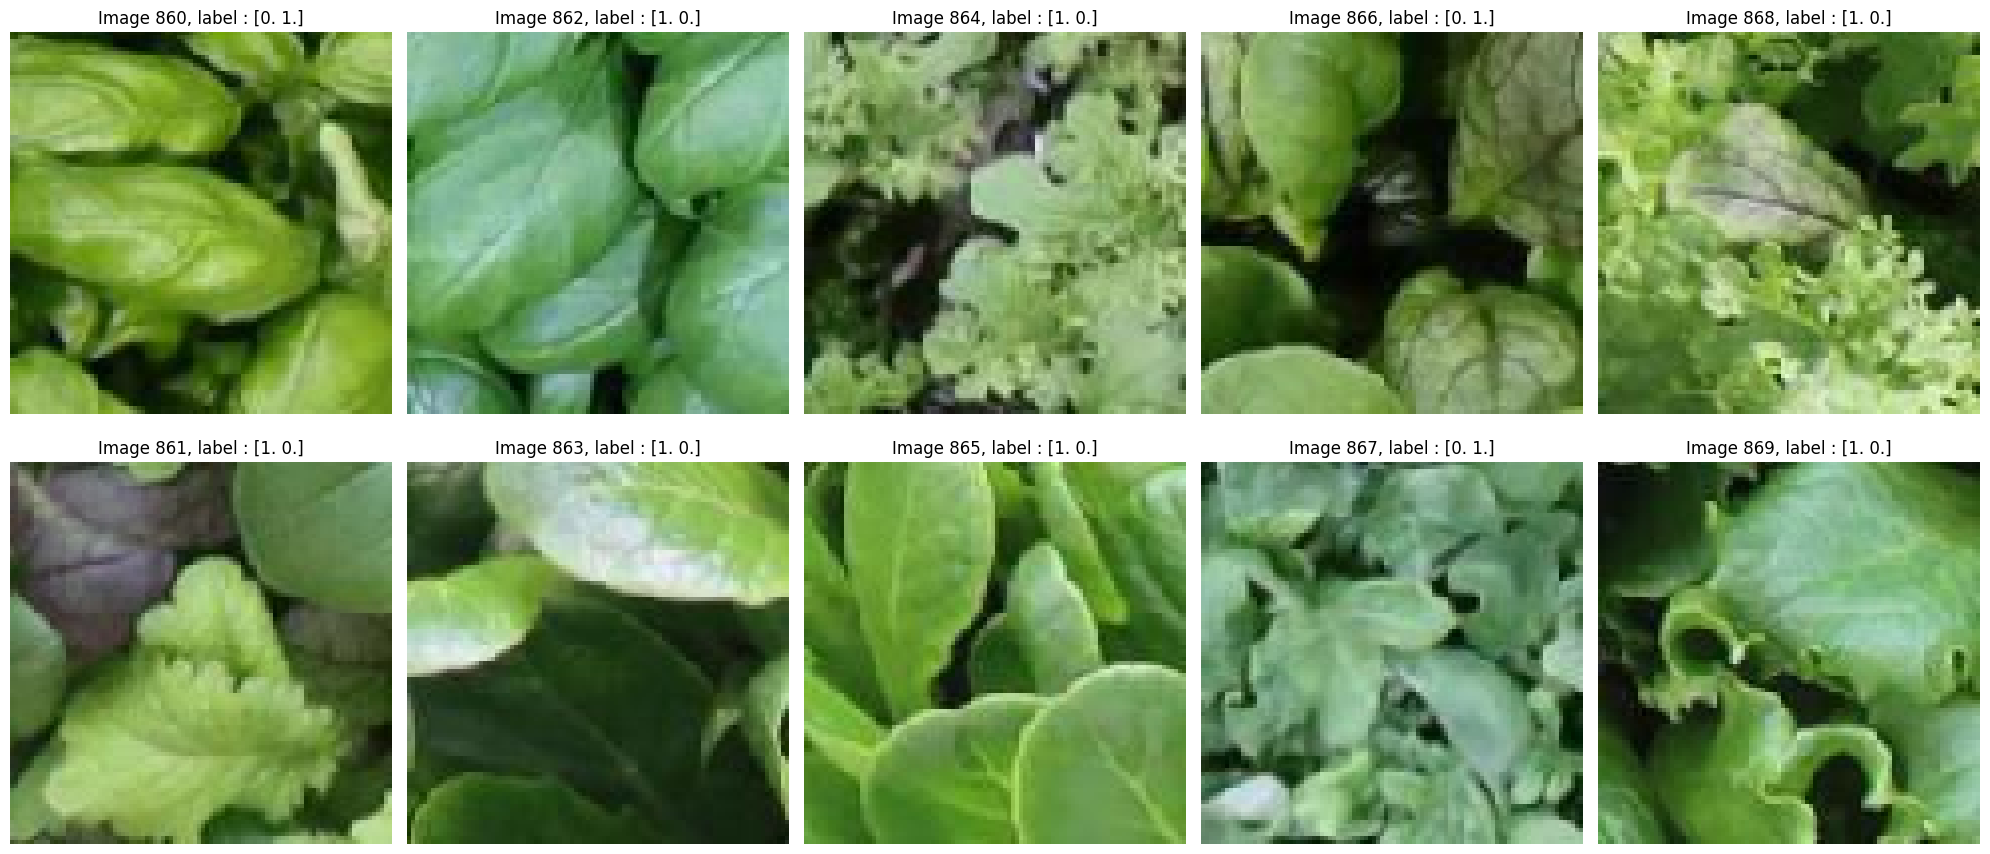

In [3]:
#-----------------------------
#       DATA INSPECTION
#-----------------------------

# Plot some pictures form the dataset
# Number of images to display
num_img = 10
random_offset = np.random.randint(5089)

# Create subplots to display data
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(data[i+ random_offset], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f'Image {i+ random_offset}, label : {labels[i+random_offset]}')
plt.tight_layout()
plt.show()


In [4]:

#----------------------------------------------------------------------------------------
#
#                                - DATA CLEAN-UP UTILS -
#
#----------------------------------------------------------------------------------------


# Remove multiple instances of the same images (Shrek and trololo "outliers")

# Hash of an image:
def dhash(image, hash_size=8):
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

# Find duplicates in the data
def clean_data(data, labels, delete = True):

    print("Cleaning data...")

    image_hashes = {} # Dictionary for unique images
    duplicates = [] # List of duplicated images

    new_data = []  # Initialize a list for unique images
    new_labels = []  # Initialize a list for unique labels

    for i, image in enumerate(data):
        h = dhash(image)
        if h in image_hashes:
            duplicates.append((i, image_hashes[h], image, np.argmax(labels[i])))
        else:
            image_hashes[h] = i
            #print("Image:",i,"- Label:", labels[i])
            new_data.append(image)
            new_labels.append(labels[i])


    # Count duplicates with different labels and different image hashes
    duplicate_counts = defaultdict(lambda: defaultdict(int))

    for i, (_,hash_value,_,label) in enumerate(duplicates):
      duplicate_counts[hash_value][label] += 1

    for hash_value, label_counts in duplicate_counts.items():
      for label, count in label_counts.items():
        # Print the most relevant counts for the duplicates
        if count > 5:
          print(f"Image Hash: {hash_value}")
          print(f"  Label: {label}, Duplicates count: {count}")
          # Delete the original copy of data
          if delete == True:
            # Get the hash of the orginal (first)image
            h_0 = dhash(data[hash_value])
            # Loop over the new_data list and search for the original image
            for i, image in enumerate(new_data):
              h = dhash(image)
              # Once found, remove it...
              if h == h_0:
                new_data.pop(i)
                new_labels.pop(i)

        elif delete == False:
          for i in range(count):
            new_data.append(data[hash_value])
            new_labels.append(labels[hash_value])


    new_data = np.array(new_data)
    new_labels = np.array(new_labels)


    print("The total number of duplicates is :", len(duplicates))


    print('Data cleaned!')

    return new_data, new_labels, duplicates, image_hashes

# A custom defined function to check on the correctness of the data
def check_correctness(data,label, cleaned_data, cleaned_label, image_hashes):
  count = 0
  #For each element in the cleaned data array, compute the hash function
  for i, image1 in enumerate(cleaned_data):
    h1 = dhash(image1)
    # Fetch the index of the corresponding image in the original dataset
    j = image_hashes[h1]
    h2 = dhash(data[j])
    if h1 == h2:
      if not (np.array_equal(cleaned_label[i],label[j])):
        count+= 1
    else:
      print("Somthing went wrong in the cleaning of the data...")
  print("Total number of inconsistent data is:", count)
  return

#----------------------------------------------------------------------------------------
# Clean the data
data_new,labels_new,duplicates,valid_images = clean_data(data,labels, True)
# Check for correctness of data cleaning
check_correctness(data, labels, data_new, labels_new, valid_images)


#----------------------------------------------------------------------------------------
#
#                                -  DATA AUGMENTATION -
#
#----------------------------------------------------------------------------------------

# Define augmenter
augmenter = tf.keras.Sequential([


  # #RANDOM ROTATION
  tf.keras.layers.RandomRotation(factor=(-0.4, 0.4)),
  # #RANDOM CROP
  #    tfkl.RandomCrop(96,96),
  # #TRANSLATION
  # tfkl.RandomTranslation(0.1,0.1, fill_mode = 'constant'),
  #BRIGHTNESS
  # tfkl.RandomBrightness(0.3, value_range=(0,1)),
  # #CONTRAST
  # tfkl.RandomContrast(-0.08),
  # #FLIP
  tfkl.RandomFlip(mode="horizontal_and_vertical"),
  # # RANDOM ZOOM
  tfkl.RandomZoom(0.1, fill_mode = 'nearest'),
  # # GAUSSIAN NOISE
  tfkl.GaussianNoise(0.1),


  ], name='Preprocessing')


# Define function to call augmenter of images
def preprocess_data(images, labels, augment=False):
    inputs =  images
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs, labels

#----------------------------------------------------------------------------------------

augment = True

Cleaning data...
Image Hash: 58
  Label: 1, Duplicates count: 97
Image Hash: 338
  Label: 0, Duplicates count: 97
The total number of duplicates is : 348
Data cleaned!
Total number of inconsistent data is: 0


The total number of PURE -> UNhealthy <- SAMPLES in the  --> X_unhealthy <-- dataset are: 1127


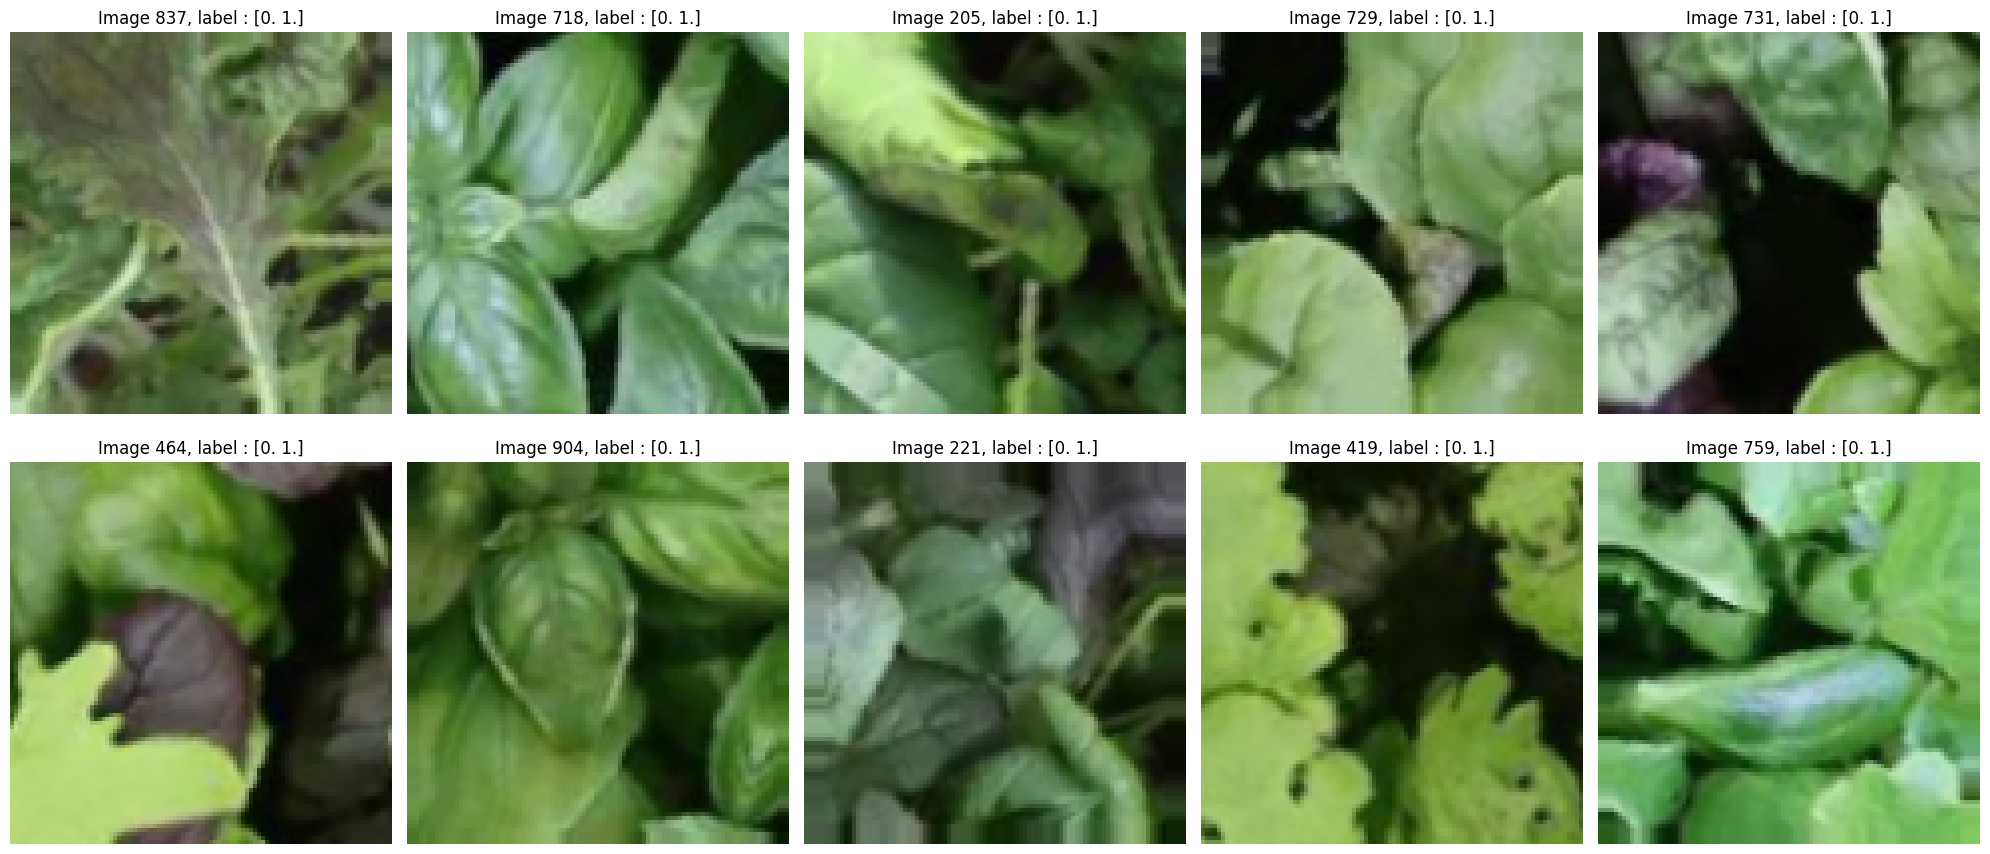

In [5]:
X_train, X_val, y_train, y_val = train_test_split(data_new, labels_new, test_size=0.1, stratify=np.argmax(labels_new,axis=1))

# Store the original dataset somewhere else
X_train0 = X_train
X_val0 = X_val
y_train0 = y_train
y_val0  = y_val



#------------------------------------------
#         APPLY OVERSAMPLING
#------------------------------------------

sampling_augmentation = True

if sampling_augmentation:
    UNhealthy_PERCENTAGE = 0.7
    #
    # First get the indices for healthy and unhealthy data
    healthy = y_train[:,0] == 1.0
    unhealthy = y_train[:,1] == 1.0

    # Perform oversampling using Mixcut primarly on the unhealthy dataset

    X_unhealthy = X_train[unhealthy]
    y_unhealthy = y_train[unhealthy]

    # Modify the seed to modify the randomization of MixCut filter
    seed = 59

    X_unhealthy, y_unhealthy = preprocess_data(X_unhealthy, y_unhealthy, augment)

    X_unhealthy = X_unhealthy.numpy()

    # Shuffle the augmented data
    perm_unhealthy = np.random.permutation(len(X_unhealthy))

    X_unhealthy = X_unhealthy[perm_unhealthy]

    # Keep a certain percentage of the data to be inserted in the new dataset
    X_unhealthy = X_unhealthy[:int(len(X_unhealthy)*UNhealthy_PERCENTAGE)]
    y_unhealthy = y_unhealthy[:int(len(y_unhealthy)*UNhealthy_PERCENTAGE)]

    print("The total number of PURE -> UNhealthy <- SAMPLES in the  --> X_unhealthy <-- dataset are:", sum(y_unhealthy[:, 1] == 1.))


    # Create subplots to display data
    fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
    for i in range(num_img):
        ax = axes[i%2, i%num_img//2]
        ax.imshow(np.clip(X_unhealthy[i+ np.random.randint(len(X_unhealthy)-10)], 0, 255))  # Display clipped item images
        ax.axis('off')
        ax.set_title(f'Image {i+ np.random.randint(len(X_unhealthy)-10)}, label : {y_unhealthy[i+np.random.randint(len(X_unhealthy)-10)]}')
    plt.tight_layout()
    plt.show()

#------------------------------------------


In [ ]:
#-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-
#                         DATA AUGMENTATION
#---------------------------------------------------------------------

# Redefine augementer for a second augmentation
augmenter = keras_cv.layers.Augmenter(
    [
        # keras_cv.layers.RandAugment(
        #     value_range=(0., 1.),
        #     augmentations_per_image=2,
        #     magnitude=0.2,
        #     magnitude_stddev=0.2,
        #     rate=0.4,
        # ),
        #keras_cv.layers.CutMix(seed = seed),
        keras_cv.layers.MixUp(seed = seed, alpha = 0.6),
        #keras_cv.layers.RandomCutout(0.3, 0.3),
        #keras_cv.layers.RandomHue(0.1, [0, 1]),

    ],
)



def preprocess_data(images, labels,augment=True):
    inputs = {"images": images, "labels":labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']


augment = True

# Apply eventual augmentation (if augment == False, this function does nothing)
X_train, y_train = preprocess_data(X_train, y_train, augment)



if augment:
  X_train = X_train.numpy()
  y_train = y_train.numpy()
  # Shuffle the data and select just a few of them
  perm = np.random.permutation(len(X_train))

  X_train = X_train[perm]
  y_train = y_train[perm]

  MIXUP_PERCENTAGE = 0.3

  # Keep a certain percentage of the data to be inserted in the new dataset
  X_train = X_train[:int(len(X_unhealthy)*MIXUP_PERCENTAGE)]
  y_train = y_train[:int(len(y_unhealthy)*MIXUP_PERCENTAGE)]
  # Merge the data...
  X_train = np.concatenate((X_train, X_train0))
  y_train = np.concatenate((y_train, y_train0))

if sampling_augmentation:
  # Merge with unhealty artificial data
  X_train = np.concatenate((X_train, X_unhealthy))
  y_train = np.concatenate((y_train, y_unhealthy))

# And shuffle them
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]



# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print("The total number of PURE -> HEALTY <- SAMPLES in the  --> X_train <-- dataset are:", sum(y_train[:, 0] == 1.))
print("The total number of PURE -> UNHEALTY <- SAMPLES in the  --> X_train <-- dataset are:", sum(y_train[:, 1] == 1.))
print("The total number of PURE -> HEALTY SAMPLES <- in the  --> X_val <-- dataset are:", sum(y_val[:, 0] == 1.))
print("The total number of PURE -> UNHEALTY SAMPLES <- in the  --> X_val <-- dataset are:", sum(y_val[:, 1] == 1.))

X_train shape: (5830, 96, 96, 3), y_train shape: (5830, 2)
X_val shape: (485, 96, 96, 3), y_val shape: (485, 2)
The total number of PURE -> HEALTY <- SAMPLES in the  --> X_train <-- dataset are: 2903
The total number of PURE -> UNHEALTY <- SAMPLES in the  --> X_train <-- dataset are: 2775
The total number of PURE -> HEALTY SAMPLES <- in the  --> X_val <-- dataset are: 306
The total number of PURE -> UNHEALTY SAMPLES <- in the  --> X_val <-- dataset are: 179



Here are the cleaned (and augmented) images...



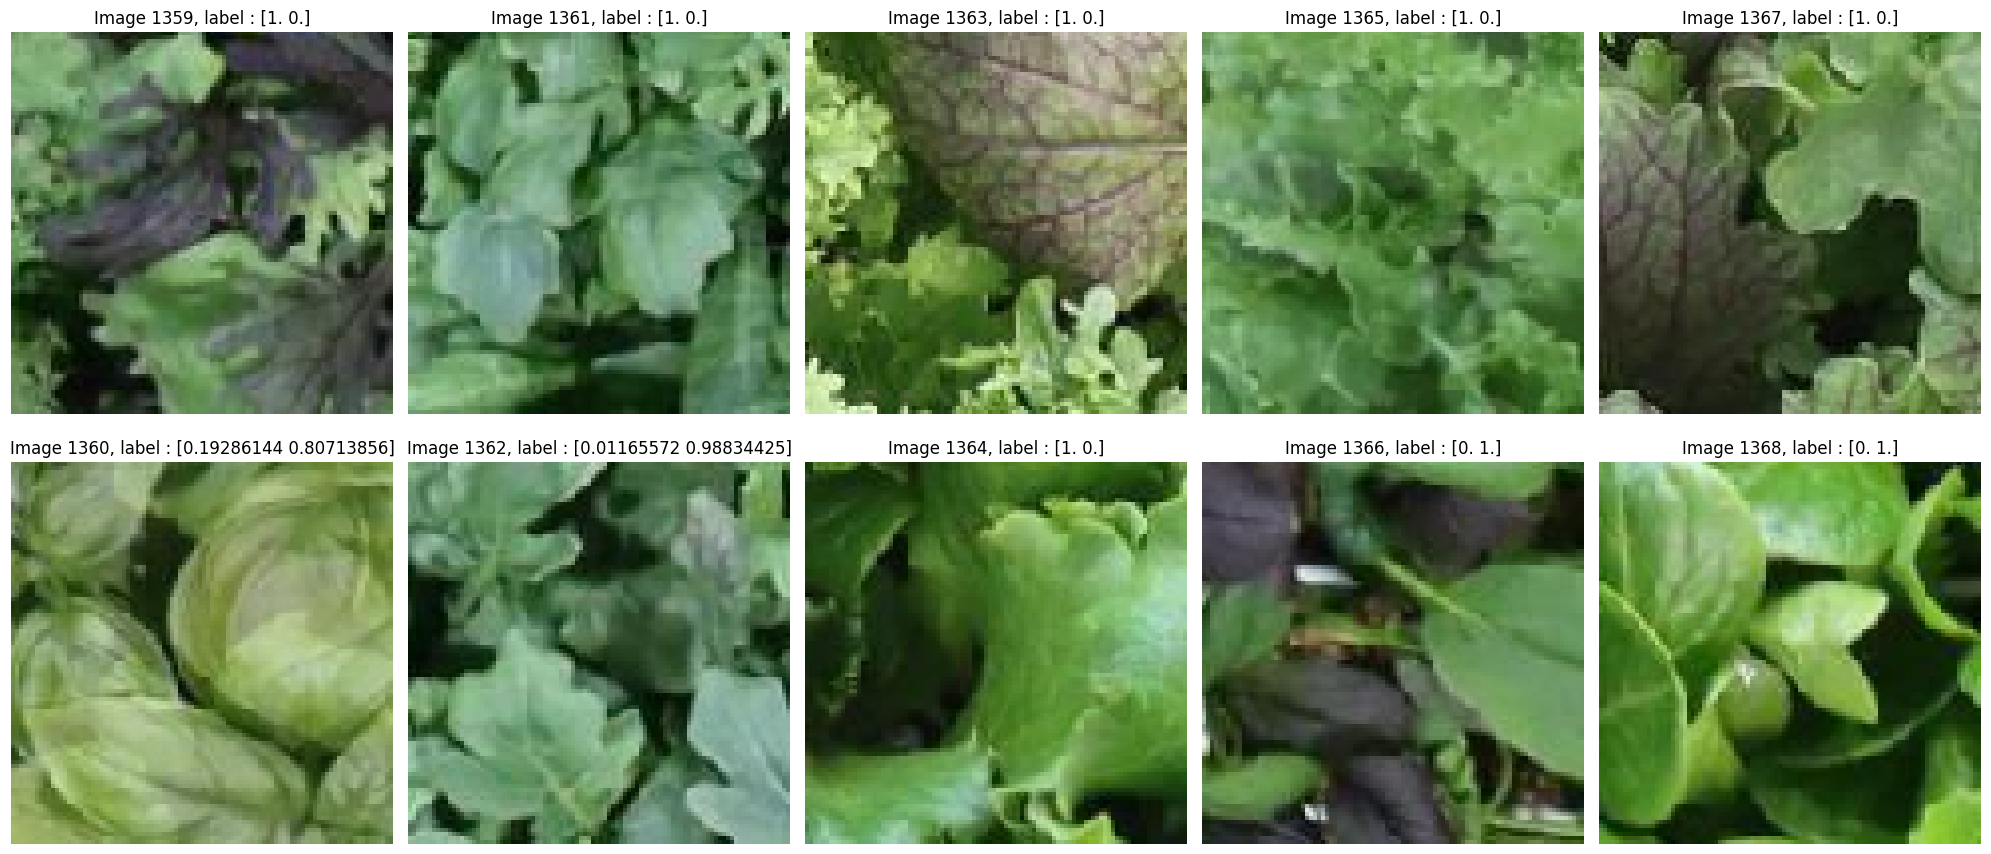

In [ ]:


num_img  = 10
random_offset = random_offset = np.random.randint(4000 - len(duplicates))


print('\nHere are the cleaned (and augmented) images...\n')
# Create subplots to display data (cleaned)
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X_train[i+ random_offset], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f'Image {i+ random_offset}, label : {y_train[i + random_offset]}')
plt.tight_layout()
plt.show()





Here are the cleaned (and augmented) images...



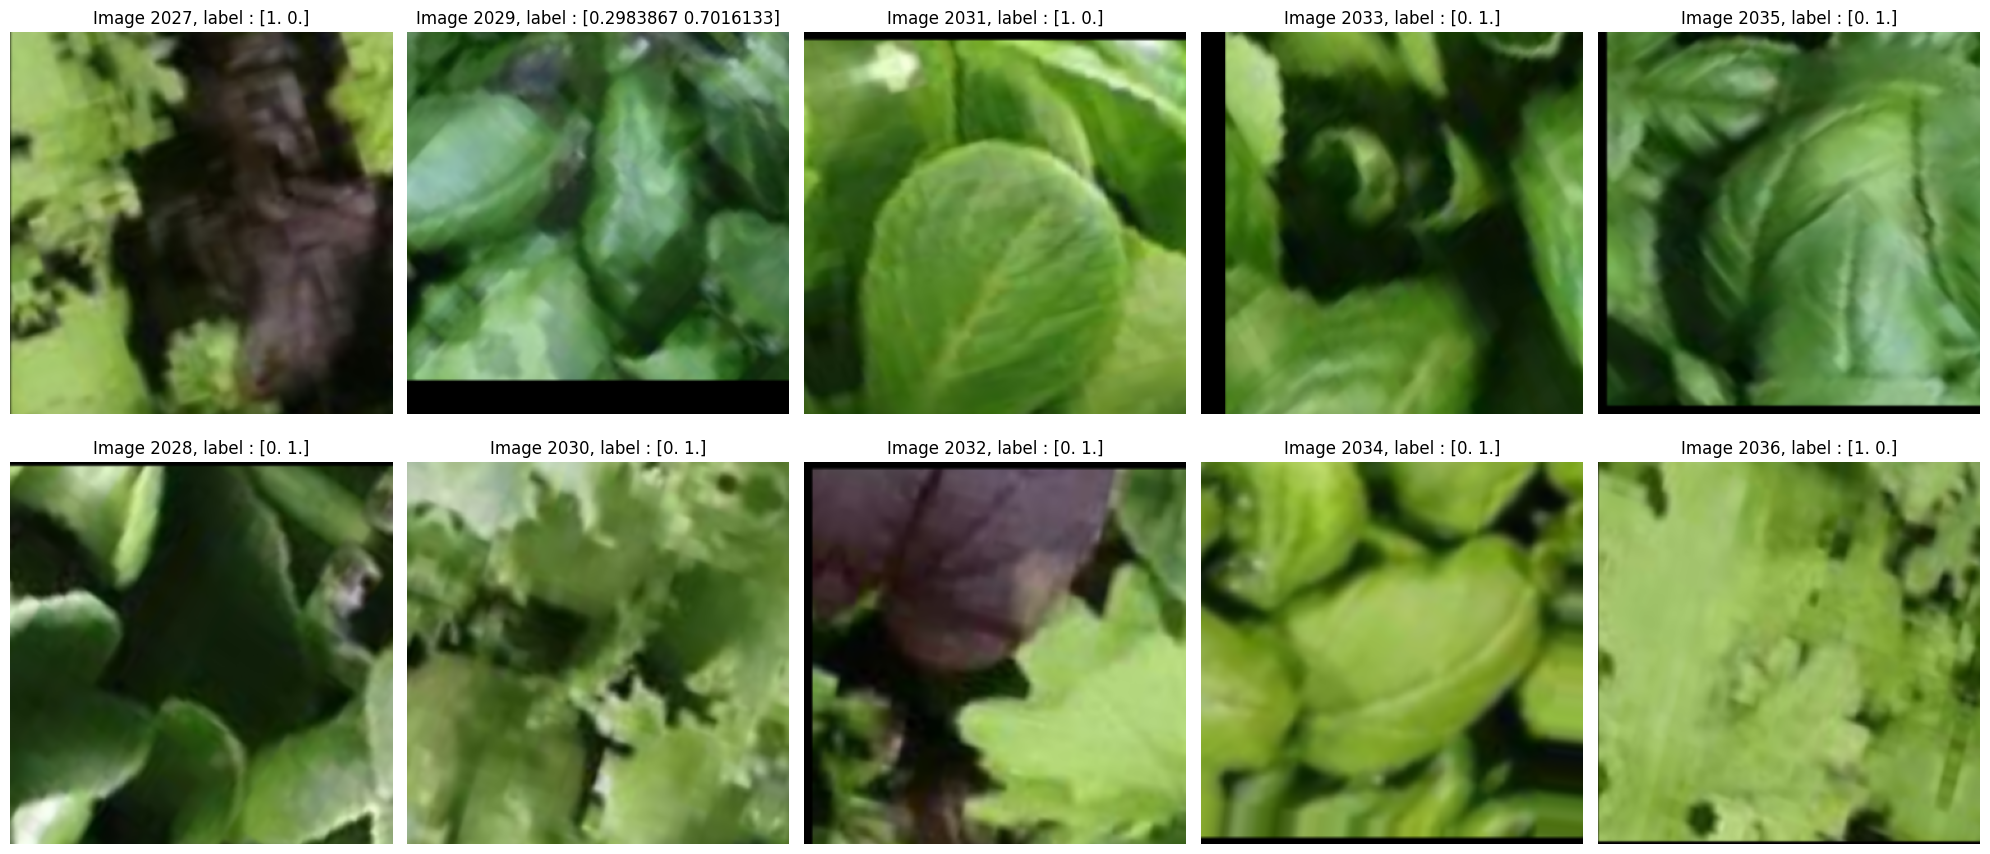

In [ ]:

preprocessing = tf.keras.Sequential([
  tfkl.Resizing(299,299),
  # #RANDOM ROTATION
  tfkl.RandomRotation(factor=(-0.4, 0.4)),
  # #TRANSLATION
  tfkl.RandomTranslation(0.1,0.1, fill_mode = 'constant'),
  # #BRIGHTNESS
  # tfkl.RandomBrightness(0.3, value_range=(0,1)),
  # #CONTRAST
  #  tfkl.RandomContrast(0.5),
  # #FLIP
    tfkl.RandomFlip(mode="horizontal_and_vertical"),
  # # RANDOM ZOOM
  tfkl.RandomZoom((-0.,-0.2), (-0.,-0.2), fill_mode = 'nearest'),
  # #RANDOM CROP
  #   tfkl.RandomCrop(96,96),

  ], name='Preprocessing')


#->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->-




num_img  = 10
random_offset = random_offset = np.random.randint(4000 - len(duplicates))


print('\nHere are the cleaned (and augmented) images...\n')
# Create subplots to display data (cleaned)
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(preprocessing(X_train[i+ random_offset]), 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f'Image {i+ random_offset}, label : {y_train[i + random_offset]}')
plt.tight_layout()
plt.show()




In [ ]:

# Define some handy global variables
BATCH_SIZE = 32
EPOCHS = 280

# --------------------------------------------------------------------
#                           LR SCHEDULER
# --------------------------------------------------------------------
def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

# Define callback for learning rate scheduler and warmup

class WarmupCosineDecay(tfk.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 0
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = model.optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)
        tfk.backend.set_value(self.model.optimizer.lr, lr)



total_steps = len(X_train)/BATCH_SIZE *EPOCHS

warmup_steps = int(0.05*total_steps)


In [ ]:


def build_model_Xception(dropout_rate = 1/4, imagenet = True, weight_decay = True, weight_factor = 5e-4,print_flag = True):


  #-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-
  #                          XCEPTION LOADING
  #---------------------------------------------------------------------
  # Create Exeption model with specified settings
  # i.e. import FE part
  if imagenet:
    xception = tfk.applications.Xception(
        input_shape=(299, 299, 3),
        include_top=False,
        weights = 'imagenet',
        pooling = "avg"
    )
  else:
    xception = tfk.applications.Xception(
        input_shape=(299, 299, 3),
        include_top=False,
        weights = None,
        pooling = "avg"
    )


  #->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->-


  #-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-
  #                         FC DEFINITION (custom)
  #---------------------------------------------------------------------

  x_input = tfk.Input(shape=(2048,), name="last_input")

  x1 =tfkl.Dense(units=256, kernel_initializer='glorot_normal',name='DenseLast2')(x_input)
  x =tfkl.BatchNormalization(name='BatchNormLast2')(x1)
  x =tfkl.Activation('relu', name='ActivationLast2')(x)
  x = tfkl.Dropout(dropout_rate,name = 'Dropout2')(x)

  x2 =tfkl.Dense(units=32, kernel_initializer='glorot_normal',name='DenseLast3')(x)
  x =tfkl.BatchNormalization(name='BatchNormLast3')(x2)
  x =tfkl.Activation('relu', name='ActivationLast3')(x)
  x = tfkl.Dropout(0.4,name = 'Dropout3')(x)

  x3 =tfkl.Dense(units=32, kernel_initializer='glorot_normal',name='DenseLast4')(x)
  x =tfkl.BatchNormalization(name='BatchNormLast4')(x3)
  x =tfkl.Activation('relu', name='ActivationLast4')(x)
  x_output =tfkl.Dropout(0.2, name = 'DropOut4')(x)



  last = tfk.Model(x_input, x_output, name="lastClassifier")

  #---------------------------------------
  #---------------------------------------

  # Create an input layer with shape (299, 299, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name = 'Input')

  preprocessing = tf.keras.Sequential([
    tfkl.Resizing(299,299),
    # #RANDOM ROTATION
    tfkl.RandomRotation(factor=(-0.4, 0.4)),
    # #TRANSLATION
     tfkl.RandomTranslation(0.1,0.1, fill_mode = 'constant'),
    # #BRIGHTNESS
    # tfkl.RandomBrightness(0.3, value_range=(0,1)),
    # #CONTRAST
    #  tfkl.RandomContrast(0.5),
    # #FLIP
    tfkl.RandomFlip(mode="horizontal_and_vertical"),
    # # RANDOM ZOOM
    tfkl.RandomZoom((-0.0,-0.2), (-0.0,-0.2), fill_mode = 'nearest'),
    # #RANDOM CROP
    #   tfkl.RandomCrop(96,96),

    ], name='Preprocessing')


  preprocessing = preprocessing(inputs)
  #---------------------------------------
  #         FE and FC CONJUNCTION
  #---------------------------------------

  x = xception(preprocessing)

  last = last(x)

  #-----------------------------------



  # Add a Dense layer with 2 units and softmax activation as the classifier
  x = tfkl.Dense(units= 2, name = 'DenseOutput')(last)
  outputs = tfkl.Activation('softmax', name='ActivationOutput')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')


  #-----------------------------------
  #         TRANSFER LEARNING
  #-----------------------------------
  if imagenet == True:

    model.get_layer('xception').trainable = False

   #-----------------------------------

  if weight_decay:
    optimizer = tfk.optimizers.AdamW( weight_decay = weight_factor)
  else:
    optimizer = tfk.optimizers.Adam()
  loss = tfk.losses.CategoricalCrossentropy()
  metrics = ['accuracy']
  # Compile the model with Categorical Cross-Entropy loss
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  # Display model summary

  model.summary()
  if print_flag:
    tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

  return model

In [ ]:
# Create the model...
model = build_model_Xception(dropout_rate = 0.5, weight_decay = False, print_flag = True)
#tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

83683744/83683744 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 lastClassifier (Functional  (None, 32)                535104    
 )                                                               
                                                                 
 DenseOutput (Dense)         (None, 2)                 66        
                                                                 
 ActivationOutput (Activati  (None, 2)                 0      

In [ ]:


# and train it
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (X_val, y_val),
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, min_lr=1e-6, mode='max'),
    WarmupCosineDecay(total_steps=total_steps, warmup_steps=warmup_steps,hold=int(warmup_steps/4),start_lr=0.0, target_lr=1e-3)
    ]
).history

Epoch 1/280
183/183 [==============================] - 36s 107ms/step - loss: 0.9141 - accuracy: 0.5022 - val_loss: 0.6682 - val_accuracy: 0.6268 - lr: 7.1373e-05
Epoch 2/280
183/183 [==============================] - 17s 90ms/step - loss: 0.7271 - accuracy: 0.5940 - val_loss: 0.5947 - val_accuracy: 0.7175 - lr: 1.4314e-04
Epoch 3/280
183/183 [==============================] - 17s 93ms/step - loss: 0.6352 - accuracy: 0.6624 - val_loss: 0.4988 - val_accuracy: 0.7691 - lr: 2.1490e-04
Epoch 4/280
183/183 [==============================] - 17s 92ms/step - loss: 0.5848 - accuracy: 0.6976 - val_loss: 0.4635 - val_accuracy: 0.7670 - lr: 2.8667e-04
Epoch 5/280
183/183 [==============================] - 17s 91ms/step - loss: 0.5498 - accuracy: 0.7202 - val_loss: 0.4493 - val_accuracy: 0.7814 - lr: 3.5843e-04
Epoch 6/280
183/183 [==============================] - 17s 92ms/step - loss: 0.5161 - accuracy: 0.7491 - val_loss: 0.4155 - val_accuracy: 0.8165 - lr: 4.3020e-04
Epoch 7/280
183/183 [======

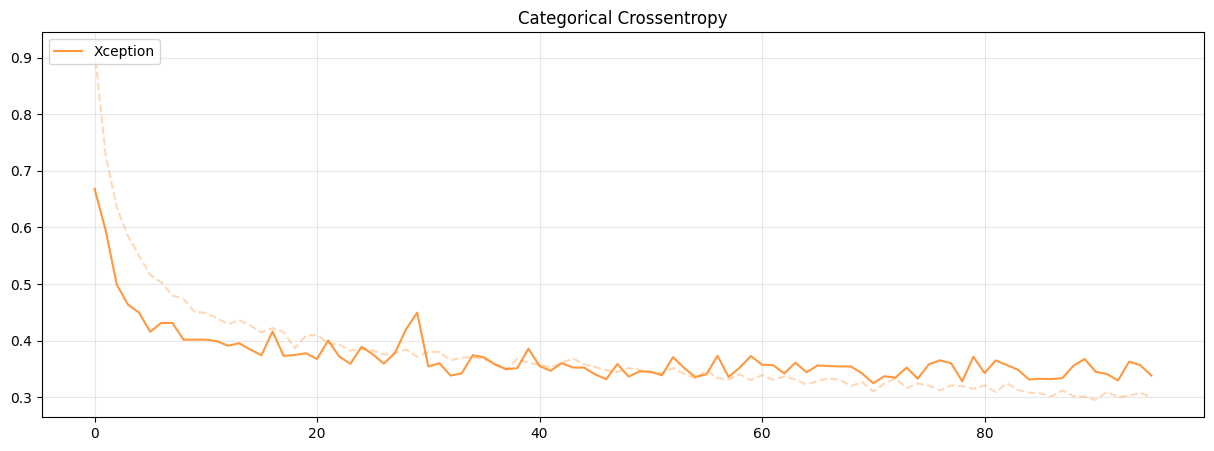

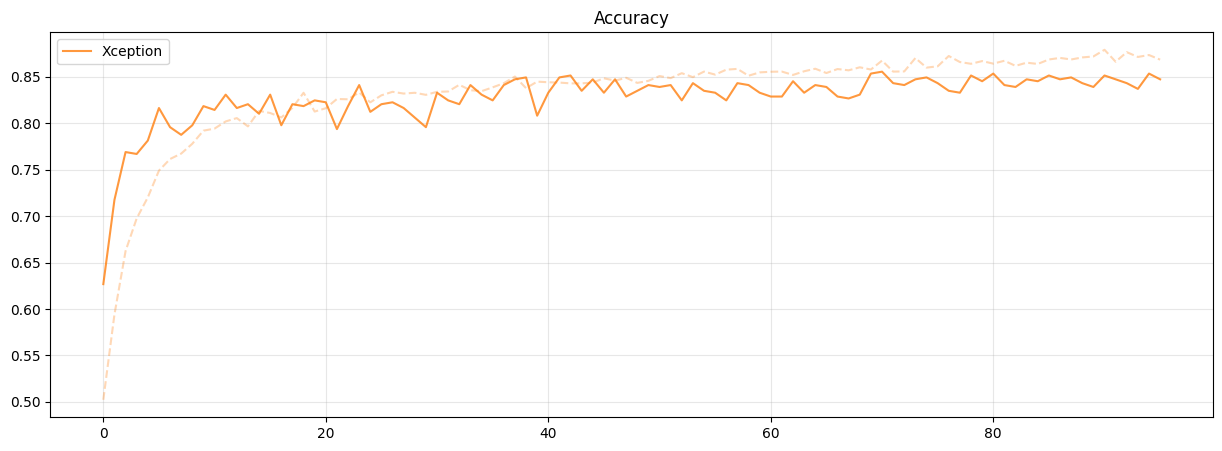

In [ ]:

# Plot the data of the model after the fist step of fine tuning
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Xception', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Xception', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

# Then save the model for successive tuning
model.save("Exeption/Xception01")
del model

In [ ]:
#---------------------------------------------------
#             STEP_2 - FINE TUNING
#---------------------------------------------------

# Load the model
model = tfk.models.load_model("Exeption/Xception01")

# Set all xception layers as trainable

model.get_layer('xception').trainable = True


for i, layer in enumerate(model.get_layer('xception').layers[:-1]):
  print(i, layer.name, layer.trainable)

#ft_model.summary()


optimizer = tfk.optimizers.Adam()
loss = tfk.losses.CategoricalCrossentropy()
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [ ]:
# Restore the training and validation datasets in case of used augmentation
X_train = X_train0
y_train = y_train0
# Merge with unhealty artifical data
X_train = np.concatenate((X_train, X_unhealthy))
y_train = np.concatenate((y_train, y_unhealthy))

print(X_train.shape)
print(y_train.shape)



# Train the model
history2 = model.fit(
    x = X_train, # We need to apply the preprocessing thought for the Xception network
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the Xception network
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, min_lr=1e-7, mode='max'),
    WarmupCosineDecay(total_steps=total_steps, warmup_steps=warmup_steps,hold=int(warmup_steps/4),start_lr=0.0, target_lr=5e-5)
    ]
).history

(5492, 96, 96, 3)
(5492, 2)
Epoch 1/280
172/172 [==============================] - 79s 286ms/step - loss: 0.7344 - accuracy: 0.7072 - val_loss: 0.5069 - val_accuracy: 0.7691 - lr: 3.3529e-06
Epoch 2/280
172/172 [==============================] - 47s 271ms/step - loss: 0.5865 - accuracy: 0.7507 - val_loss: 0.4743 - val_accuracy: 0.7938 - lr: 6.7255e-06
Epoch 3/280
172/172 [==============================] - 47s 272ms/step - loss: 0.4957 - accuracy: 0.7749 - val_loss: 0.4922 - val_accuracy: 0.7732 - lr: 1.0098e-05
Epoch 4/280
172/172 [==============================] - 47s 271ms/step - loss: 0.4382 - accuracy: 0.8063 - val_loss: 0.4420 - val_accuracy: 0.7835 - lr: 1.3471e-05
Epoch 5/280
172/172 [==============================] - 47s 273ms/step - loss: 0.3953 - accuracy: 0.8245 - val_loss: 0.4407 - val_accuracy: 0.7753 - lr: 1.6843e-05
Epoch 6/280
172/172 [==============================] - 47s 271ms/step - loss: 0.3743 - accuracy: 0.8310 - val_loss: 0.4805 - val_accuracy: 0.7753 - lr: 2.021

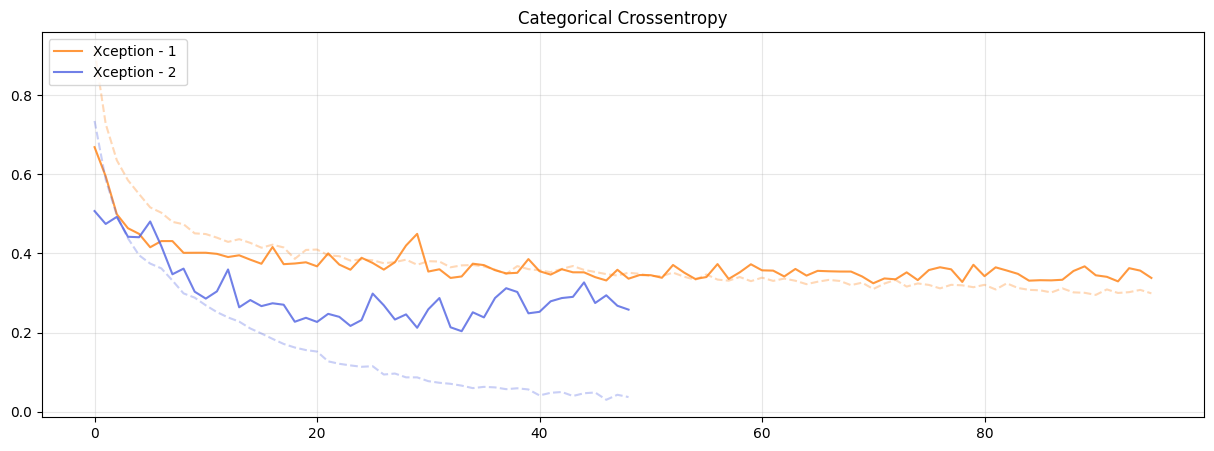

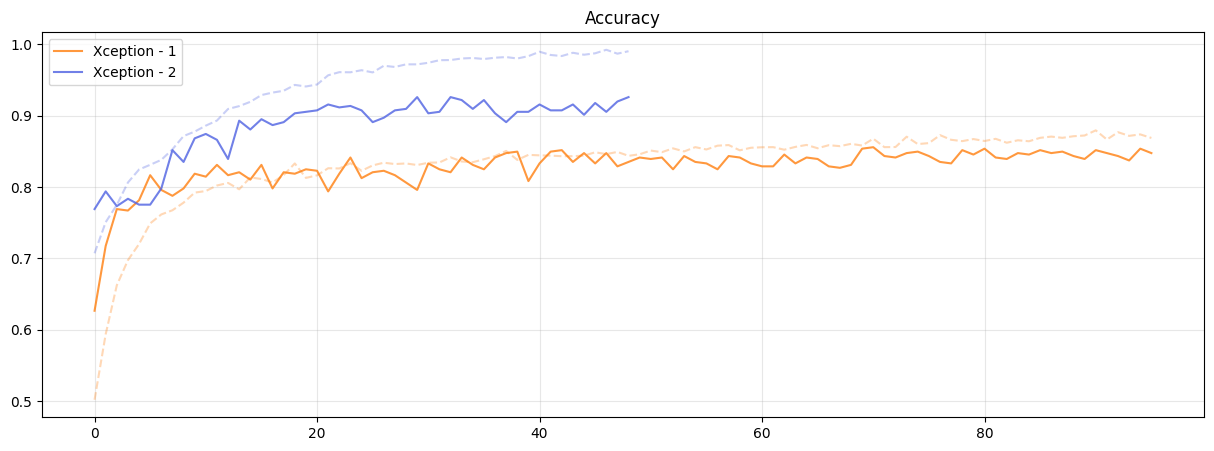

In [ ]:

# Plot the data of the model after the fist step of fine tuning
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Xception - 1 ', alpha=.8, color='#ff7f0e')
plt.plot(history2['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history2['val_loss'], label='Xception - 2', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Xception - 1', alpha=.8, color='#ff7f0e')
plt.plot(history2['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history2['val_accuracy'], label='Xception - 2', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

# Then save the model for successive tuning
model.save("Exeption/Xception02")
del model

In [ ]:
X_t = X_train
y_t = y_train
X_v = X_val
y_v = y_val

16/16 [==============================] - 14s 83ms/step
[0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0]
[[9.8836261e-01 1.1637414e-02]
 [9.8485214e-01 1.5147848e-02]
 [9.8674273e-01 1.3257273e-02]
 [9.9930918e-01 6.9083337e-04]
 [2.1464618e-02 9.7853535e-01]
 [9.9675214e-01 3.2478708e-03]
 [9.9976057e-01 2.3946393e-04]
 [9.7348207e-01 2.6517898e-02]
 [1.0554317e-01 8.9445686e-01]
 [1.4168280e-05 9.9998581e-01]
 [9.9798191e-01 2.0180705e-03]
 [9.9952602e-01 4.7398827e-04]
 [9.0134457e-02 9.0986550e-01]
 [9.9936932e-01 6.3067063e-04]
 [9.9986160e-01 1.3841409e-04]
 [1.0260197e-02 9.8973978e-01]
 [9.4752365e-01 5.2476373e-02]
 [9.9974328e-01 2.5673510e-04]
 [9.4425845e-01 5.5741530e-02]
 [9.9781752e-01 2.1824380e-03]]
0.9216494560241699


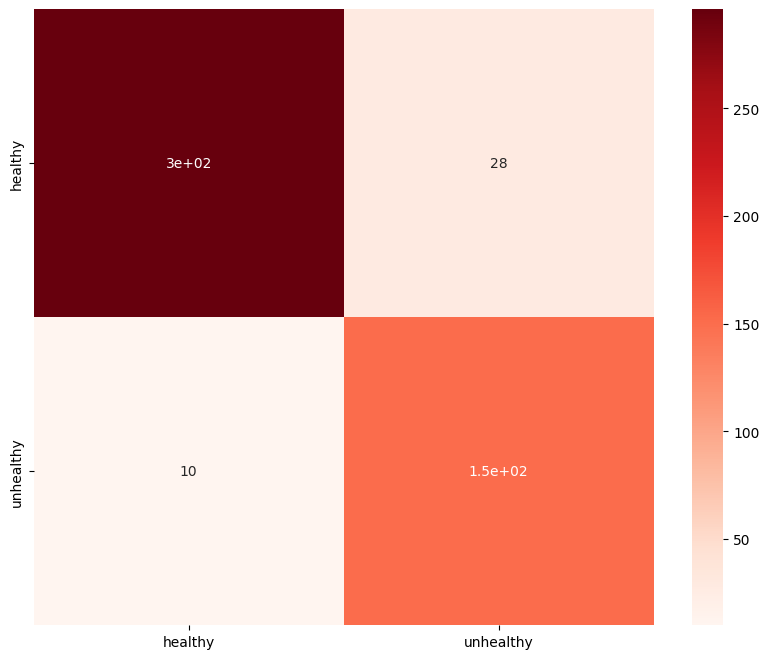

In [6]:
# Quick check on the correctness of output

model = tfk.models.load_model("Exeption/Xception02")


predictions = model.predict(X_val)  # IMAGES NORMALIZED IN THE RANGE 0,1
test_accuracy = model.evaluate(X_val ,y_val,verbose=0)[-1]

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Reds', annot=True)

print("Test accuracy": test_accuracy)
del model